In [1]:
# Data processing
import iris
import iris.analysis
import iris.coord_categorisation
import warnings
warnings.filterwarnings('ignore', module='iris')
import numpy as np
from pathlib import Path
from scipy import stats
# Visualization
import cartopy.util
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import FuncFormatter
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
def m2km(x, pos):
    '''Convert meters to kilometers when plotting axis labels'''
    return int(x*1e-3)
def custom_ctcklbls(x, pos):
    '''Custom format for colorbar tick labels'''
    return '{:1.1f}'.format(x)
plt.rcParams['mathtext.default'] = 'regular'

In [2]:
# Switches
base_exp = 'BASE'
sens_exp = 'FULL'
var = 'noy'
w_rono2 = True
savefig = True
publish = True

In [3]:
# Choose experiments
job_dict = {'BASE OLD':'xojnd',
            'BASE'    :'xojng',
            'CHEM'    :'xojnh',
            'MARI'    :'xojni',
            'FIRE'    :'xojnc',
            'FULL'    :'xojnl',
            'ORIG'    :'xolnb',
            'UPDT'    :'xolna'}
base_job = job_dict[base_exp]
sens_job = job_dict[sens_exp]
# Choose variables
var_dict = {'molar_mass': {'o3':47.997, 'no':30.006, 'no2':46.006, 'hono':47.013, 'ho2no2':79.01224, 'hno3':63.012, 'n2o5':108.01, 'pan':121.0489, 'ppan':135.0755,
                           'meono2':77.0394, 'etono2':91.0660, 'nprono2':105.0926, 'iprono2':105.0926},
            'str': {'o3':'$O_3$', 'no':'NO', 'no2':'$NO_2$', 'hono':'HONO', 'ho2no2':'$HO_2NO_2$', 'hno3':'$HNO_3$', 'n2o5':'N_2O_5', 'pan':'PAN', 'ppan':'PPN', 
                    'nox':'$NO_x$', 'noy':'$NO_y$', 'meono2':'$MeONO_2$', 'etono2':'$EtONO_2$', 'nprono2':'$nPrONO_2$', 'iProno2':'$iPrONO_2$'}}
# Read data
path_to_ukca = Path.cwd().parent / 'data'
M_air = 28.97 # molar mass of dry air [g mol-1]
if var == 'noy':
    coeff_hono = (M_air/var_dict['molar_mass']['hono'])*1e9
    coeff_ho2no2 = (M_air/var_dict['molar_mass']['ho2no2'])*1e9
    coeff_hno3 = (M_air/var_dict['molar_mass']['hno3'])*1e9
    coeff_n2o5 = (M_air/var_dict['molar_mass']['n2o5'])*1e9
    coeff_pan = (M_air/var_dict['molar_mass']['pan'])*1e9
    coeff_ppan = (M_air/var_dict['molar_mass']['ppan'])*1e9
    coeff_meono2 = (M_air/var_dict['molar_mass']['meono2'])*1e9
    coeff_etono2 = (M_air/var_dict['molar_mass']['etono2'])*1e9
    coeff_nprono2 = (M_air/var_dict['molar_mass']['nprono2'])*1e9
    coeff_iprono2 = (M_air/var_dict['molar_mass']['iprono2'])*1e9
    base_hono = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_hono.nc'), 'hono')*coeff_hono
    sens_hono = iris.load_cube(str(path_to_ukca / sens_job / f'{sens_job}_hono.nc'), 'hono')*coeff_hono
    base_ho2no2 = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_ho2no2.nc'), 'ho2no2')*coeff_ho2no2
    sens_ho2no2 = iris.load_cube(str(path_to_ukca / sens_job / f'{sens_job}_ho2no2.nc'), 'ho2no2')*coeff_ho2no2
    base_hno3 = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_hno3.nc'), 'hno3')*coeff_hno3
    sens_hno3 = iris.load_cube(str(path_to_ukca / sens_job / f'{sens_job}_hno3.nc'), 'hno3')*coeff_hno3
    base_n2o5 = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_n2o5.nc'), 'n2o5')*coeff_n2o5
    sens_n2o5 = iris.load_cube(str(path_to_ukca / sens_job / f'{sens_job}_n2o5.nc'), 'n2o5')*coeff_n2o5
    base_pan = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_pan.nc'), 'pan')*coeff_pan
    sens_pan = iris.load_cube(str(path_to_ukca / sens_job / f'{sens_job}_pan.nc'), 'pan')*coeff_pan
    base_ppan = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_ppan.nc'), 'ppan')*coeff_ppan
    sens_ppan = iris.load_cube(str(path_to_ukca / sens_job / f'{sens_job}_ppan.nc'), 'ppan')*coeff_ppan
    sens_meono2 = iris.load_cube(str(path_to_ukca / sens_job / f'{sens_job}_meono2.nc'), 'meono2')*coeff_meono2
    sens_etono2 = iris.load_cube(str(path_to_ukca / sens_job / f'{sens_job}_etono2.nc'), 'etono2')*coeff_etono2
    sens_nprono2 = iris.load_cube(str(path_to_ukca / sens_job / f'{sens_job}_nprono2.nc'), 'nprono2')*coeff_nprono2
    sens_iprono2 = iris.load_cube(str(path_to_ukca / sens_job / f'{sens_job}_iprono2.nc'), 'iprono2')*coeff_iprono2
    base = base_hono + base_ho2no2 + base_hno3 + base_n2o5 + base_pan + base_ppan
    if w_rono2:
        rno3 = sens_meono2 + sens_etono2 + sens_nprono2 + sens_iprono2
        sens = sens_hono + sens_ho2no2 + sens_hno3 + sens_n2o5 + sens_pan + sens_ppan + rno3
        rno3 = rno3[24::,...]
        iris.coord_categorisation.add_season(rno3, 'time', name='season')
        iris.coord_categorisation.add_season_year(rno3, 'time', name='year')
    else:
        sens = sens_hono + sens_ho2no2 + sens_hno3 + sens_n2o5 + sens_pan + sens_ppan   
else:
    var_coeff = (M_air/var_dict['molar_mass'][var])*1e9
    base = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_{var}.nc'), var)*var_coeff
    sens = iris.load_cube(str(path_to_ukca / sens_job / f'{sens_job}_{var}.nc'), var)*var_coeff
# Remove the first 2 years as a spin up
base = base[24::,...]
sens = sens[24::,...]
# Add season and year coordinates
iris.coord_categorisation.add_season(base, 'time', name='season')
iris.coord_categorisation.add_season(sens, 'time', name='season')
iris.coord_categorisation.add_season_year(base, 'time', name='year')
iris.coord_categorisation.add_season_year(sens, 'time', name='year')   
# Simplify dimensions
nlons = base.coord('longitude').shape[0]
nlats = base.coord('latitude').shape[0]
nlevs = base.coord('level_height')[0:23].shape[0]
lons = base.coord('longitude').points #
lats = base.coord('latitude').points

In [4]:
# Path to figures
path_to_figs = Path.cwd().parent.parent.parent / 'results' / f'{sens_job}-{base_job}' / var
path_to_figs.mkdir(exist_ok=True)
if publish:
    mpl.rcParams['xtick.labelsize'] = 12 # 25
    mpl.rcParams['ytick.labelsize'] = 12 # 25
    mpl.rcParams['axes.titlesize'] = 12 # 40
    mpl.rcParams['axes.labelsize'] = 12 # 30
    plt.rcParams['font.size'] = 12 # 30

In [5]:
def fdr_threshold(pvalues, alpha=0.05*2):
    '''Compute the FDR threshod after Wilks (2016).
    Credit to https://fabienmaussion.info/2017/01/30/trendy-triangles-fdr/'''
    p = np.sort(np.asarray(pvalues).flatten())
    n = len(p)
    return np.max(np.where(p <= np.arange(1, n+1) / n * alpha, p, 0))

### Boundary layer seasonal means

In [6]:
# Extract time series of boundary layer (0-2 km) seasonal means
base_pbl_djf = (base.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
sens_pbl_djf = (sens.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
base_pbl_mam = (base.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
sens_pbl_mam = (sens.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
base_pbl_jja = (base.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
sens_pbl_jja = (sens.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
base_pbl_son = (base.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
sens_pbl_son = (sens.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
# Check if boundary layer seasonal mean differences between two experiments are normally distributed using the Shapiro–Wilk test
shapiro_pbl_djf_p = np.empty([nlats,nlons])
shapiro_pbl_mam_p = np.empty([nlats,nlons])
shapiro_pbl_jja_p = np.empty([nlats,nlons])
shapiro_pbl_son_p = np.empty([nlats,nlons])
for i, lat in enumerate(base.coord('latitude').points):
    for j, lon in enumerate(base.coord('longitude').points):
        shapiro_pbl_djf_p[i,j] = stats.shapiro(base_pbl_djf.data[:,i,j] - sens_pbl_djf.data[:,i,j])[1]
        shapiro_pbl_mam_p[i,j] = stats.shapiro(base_pbl_mam.data[:,i,j] - sens_pbl_mam.data[:,i,j])[1]
        shapiro_pbl_jja_p[i,j] = stats.shapiro(base_pbl_jja.data[:,i,j] - sens_pbl_jja.data[:,i,j])[1]
        shapiro_pbl_son_p[i,j] = stats.shapiro(base_pbl_son.data[:,i,j] - sens_pbl_son.data[:,i,j])[1]
# See if boundary layer seasonal mean differences between two experiments are statitically significant using
# (a) paired sample t-test if data is normally distributed, and
# (b) Wilcoxon signed-rank test if data is not normally distributed
pbl_djf_p = np.empty([nlats,nlons])
pbl_mam_p = np.empty([nlats,nlons])
pbl_jja_p = np.empty([nlats,nlons])
pbl_son_p = np.empty([nlats,nlons])
for i, lat in enumerate(base.coord('latitude').points):
    for j, lon in enumerate(base.coord('longitude').points):
        if shapiro_pbl_djf_p[i,j] > 0.05:
            pbl_djf_p[i,j] = stats.ttest_rel(base_pbl_djf.data[:,i,j], sens_pbl_djf.data[:,i,j])[1]
        else: 
            pbl_djf_p[i,j] = stats.wilcoxon(base_pbl_djf.data[:,i,j], sens_pbl_djf.data[:,i,j])[1]
        if shapiro_pbl_mam_p[i,j] > 0.05:
            pbl_mam_p[i,j] = stats.ttest_rel(base_pbl_mam.data[:,i,j], sens_pbl_mam.data[:,i,j])[1]
        else:
            pbl_mam_p[i,j] = stats.wilcoxon(base_pbl_mam.data[:,i,j], sens_pbl_mam.data[:,i,j])[1]
        if shapiro_pbl_jja_p[i,j] > 0.05:
            pbl_jja_p[i,j] = stats.ttest_rel(base_pbl_jja.data[:,i,j], sens_pbl_jja.data[:,i,j])[1]
        else:
            pbl_jja_p[i,j] = stats.wilcoxon(base_pbl_jja.data[:,i,j], sens_pbl_jja.data[:,i,j])[1]
        if shapiro_pbl_son_p[i,j] > 0.05:
            pbl_son_p[i,j] = stats.ttest_rel(base_pbl_son.data[:,i,j], sens_pbl_son.data[:,i,j])[1]
        else:
            pbl_son_p[i,j] = stats.wilcoxon(base_pbl_son.data[:,i,j], sens_pbl_son.data[:,i,j])[1]
# Calculate boundary layer seasonal mean differences
base_pbl_djf_mean = base_pbl_djf.collapsed('year', iris.analysis.MEAN)
base_pbl_mam_mean = base_pbl_mam.collapsed('year', iris.analysis.MEAN)
base_pbl_jja_mean = base_pbl_jja.collapsed('year', iris.analysis.MEAN)
base_pbl_son_mean = base_pbl_son.collapsed('year', iris.analysis.MEAN)
sens_pbl_djf_mean = sens_pbl_djf.collapsed('year', iris.analysis.MEAN)
sens_pbl_mam_mean = sens_pbl_mam.collapsed('year', iris.analysis.MEAN)
sens_pbl_jja_mean = sens_pbl_jja.collapsed('year', iris.analysis.MEAN)
sens_pbl_son_mean = sens_pbl_son.collapsed('year', iris.analysis.MEAN)
pbl_djf_diff = sens_pbl_djf_mean - base_pbl_djf_mean
pbl_mam_diff = sens_pbl_mam_mean - base_pbl_mam_mean
pbl_jja_diff = sens_pbl_jja_mean - base_pbl_jja_mean
pbl_son_diff = sens_pbl_son_mean - base_pbl_son_mean
# Add cyclic point for plotting on a global map
cyc_pbl_djf_diff, cyclic_lons = cartopy.util.add_cyclic_point(pbl_djf_diff.data, coord=pbl_djf_diff.coord('longitude').points)
cyc_pbl_mam_diff = cartopy.util.add_cyclic_point(pbl_mam_diff.data)
cyc_pbl_jja_diff = cartopy.util.add_cyclic_point(pbl_jja_diff.data)
cyc_pbl_son_diff = cartopy.util.add_cyclic_point(pbl_son_diff.data)
cyc_base_pbl_djf_mean = cartopy.util.add_cyclic_point(base_pbl_djf_mean.data)
cyc_base_pbl_mam_mean = cartopy.util.add_cyclic_point(base_pbl_mam_mean.data)
cyc_base_pbl_jja_mean = cartopy.util.add_cyclic_point(base_pbl_jja_mean.data)
cyc_base_pbl_son_mean = cartopy.util.add_cyclic_point(base_pbl_son_mean.data)
cyc_sens_pbl_djf_mean = cartopy.util.add_cyclic_point(sens_pbl_djf_mean.data)
cyc_sens_pbl_mam_mean = cartopy.util.add_cyclic_point(sens_pbl_mam_mean.data)
cyc_sens_pbl_jja_mean = cartopy.util.add_cyclic_point(sens_pbl_jja_mean.data)
cyc_sens_pbl_son_mean = cartopy.util.add_cyclic_point(sens_pbl_son_mean.data)
# Find max boundary layer seasonal mean
print(max(np.max(base_pbl_djf_mean.data), np.max(sens_pbl_djf_mean.data)))
print(max(np.max(base_pbl_mam_mean.data), np.max(sens_pbl_mam_mean.data)))
print(max(np.max(base_pbl_jja_mean.data), np.max(sens_pbl_jja_mean.data)))
print(max(np.max(base_pbl_son_mean.data), np.max(sens_pbl_son_mean.data)))
# Check for false discovery
print('FDR: ', fdr_threshold(pbl_djf_p), fdr_threshold(pbl_mam_p), fdr_threshold(pbl_jja_p), fdr_threshold(pbl_son_p))

/local/mwe14avu/miniconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


8.978415
5.4651318
4.9566727
6.931694
FDR:  0.05120419181653776 0.049069504170404024 0.06573031357481997 0.05468546610219659


- CHEM-BASE O3: 94.47014 67.15967 67.81758 70.99066 FDR:  4.85273119226e-05 0.0 0.0 0.0
- MARI-BASE O3: 92.44435 67.586365 67.81758 70.99066 FDR:  0.027376744728255603 0.0 0.0 0.005844106297217985
- FULL-BASE O3: 94.54146 67.43663 69.066635 70.99066 FDR:  0.031184292595637896 0.0 0.0 0.020536157398506963
- FULL-BASE NOy wo RONO2: 8.978415 5.4347267 4.9211984 6.931694 FDR:  0.024367906601376044 1.8490486323717958e-06 0.0 0.025868126507294417
- CHEM-BASE NOy w RONO2: 8.978415 5.5679717 4.799015 6.931694 FDR:  0.029899259778976416 0.03429721382258202 0.03727214163164655 0.036449192986989155
- MARI-BASE NOy w RONO2: 8.978415 5.6025095 5.122735 6.931694 FDR:  0.04146987553672822 0.04173921305855974 0.046621018325410435 0.041750136029032124
- FULL-BASE NOy w RONO2: 8.978415 5.4651318 4.9566727 6.931694 FDR:  0.05120419181653776 0.049069504170404024 0.06573031357481997 0.05468546610219659

In [7]:
# Boundary layer seasonal mean difference plotting parameters
if var == 'o3':
    pbl_mean_cf_kwargs = dict(transform=ccrs.PlateCarree(), levels=np.arange(0,110,10))
elif var == 'noy':
    pbl_mean_cf_kwargs = dict(transform=ccrs.PlateCarree(), levels=np.arange(0,11,1))
pbl_diff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r')
pbl_pval_sc_kwargs = dict(transform=ccrs.PlateCarree(), s=10, c='k', marker='.', alpha=1)
fdr_pbl = True # turn FDR on/off
def stipple_pbl(cube, pval_arr, fdr, central_long=0):
    '''Stipple areas where p-values are statistically significant. 
    Inspired by https://groups.google.com/forum/#!topic/scitools-iris/Xm2IhQ6YKQA'''
    xOrg = cube.coord('longitude').points 
    yOrg = cube.coord('latitude').points
    nlon = len(xOrg) 
    nlat = len(yOrg) 
    xData = np.reshape( np.tile(xOrg, nlat), pval_arr.shape ) 
    yData = np.reshape( np.repeat(yOrg, nlon), pval_arr.shape )
    if fdr:
        thresh = fdr_threshold(pval_arr) # false discovery rate threshold
    else:
        thresh=0.05
    sigPoints = pval_arr < thresh 
    xPoints = xData[sigPoints] - central_long
    yPoints = yData[sigPoints]
    return (xPoints, yPoints)

In [8]:
# Find min and max absolute boundary layer seasonal mean difference
print(min([np.min(cyc_pbl_djf_diff.data), np.min(cyc_pbl_mam_diff.data), np.min(cyc_pbl_jja_diff.data), np.min(cyc_pbl_son_diff.data)]))
print(max([np.max(cyc_pbl_djf_diff.data), np.max(cyc_pbl_mam_diff.data), np.max(cyc_pbl_jja_diff.data), np.max(cyc_pbl_son_diff.data)]))
# Find min and max % boundary layer seasonal mean difference
print(min([np.min(cyc_pbl_djf_diff.data/cyc_base_pbl_djf_mean.data*100), np.min(cyc_pbl_mam_diff.data/cyc_base_pbl_mam_mean.data*100), 
           np.min(cyc_pbl_jja_diff.data/cyc_base_pbl_jja_mean.data*100), np.min(cyc_pbl_son_diff.data/cyc_base_pbl_son_mean.data*100)]))
print(max([np.max(cyc_pbl_djf_diff.data/cyc_base_pbl_djf_mean.data*100), np.max(cyc_pbl_mam_diff.data/cyc_base_pbl_mam_mean.data*100), 
           np.max(cyc_pbl_jja_diff.data/cyc_base_pbl_jja_mean.data*100), np.max(cyc_pbl_son_diff.data/cyc_base_pbl_son_mean.data*100)]))

-0.9853883
1.2527189
-22.743944
843.24054


- CHEM-BASE O3: -6.4614296 6.8441925 -13.359586 19.08021
- MARI-BASE O3: -5.0836563 7.6860695 -12.6582365 24.622028
- FULL-BASE O3: -5.875229 6.597744 -12.732835 30.897097
- CHEM-BASE NOy w RONO2: -0.98270035 1.184288 -28.148079 124.478615
- MARI-BASE NOy w RONO2: -0.8188243 1.3464642 -20.732325 771.98444
- FULL-BASE NOy w RONO2: -0.9853883 1.2527189 -22.743944 843.24054


- FULL-BASE NOy wo RONO2: -1.012675 1.2200456 -37.405403 110.088776

In [9]:
# Additional plotting parameteres for boundary layer seasonal mean summary
if var == 'o3':
    pbl_glb_absdiff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.arange(-10,12,2)) # maybe 8?
    pbl_glb_pctdiff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.arange(-35,40,5)) 
elif var == 'noy':
    pbl_glb_absdiff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.arange(-1.4,1.6,0.2))
    pbl_glb_pctdiff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.arange(-140,160,20), extend='max')

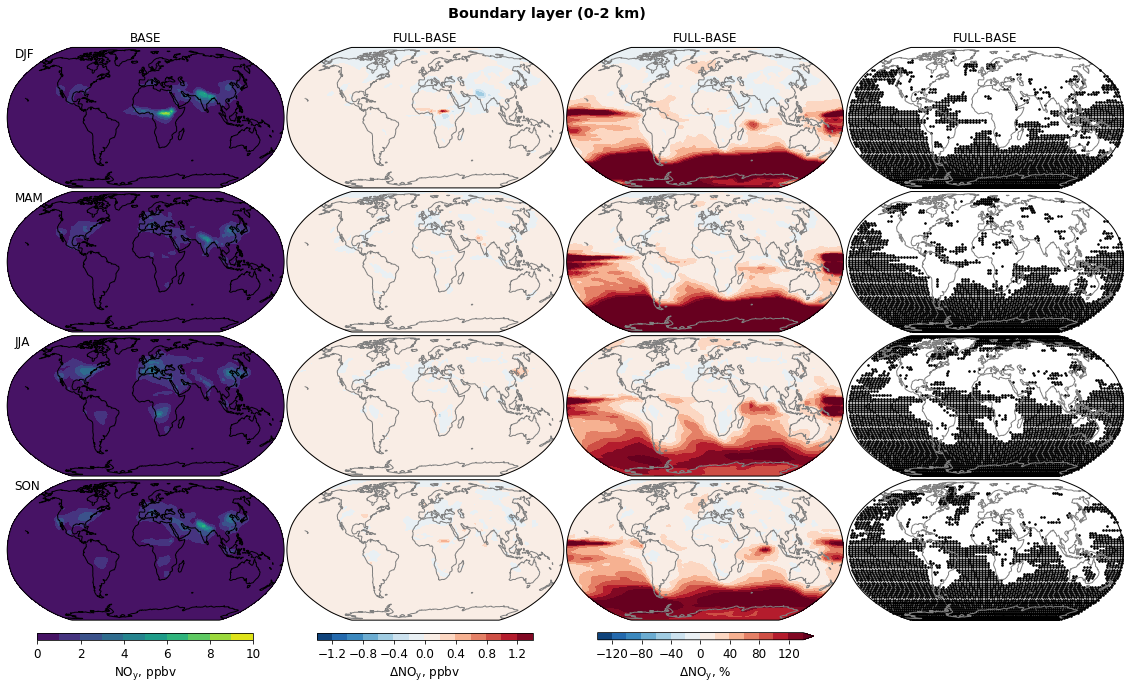

In [10]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20,20), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
ax[0,0].contourf(cyclic_lons, lats, cyc_base_pbl_djf_mean.data, **pbl_mean_cf_kwargs)
ax[0,1].contourf(cyclic_lons, lats, cyc_pbl_djf_diff.data, **pbl_glb_absdiff_cf_kwargs)
ax[0,2].contourf(cyclic_lons, lats, cyc_pbl_djf_diff.data/cyc_base_pbl_djf_mean.data*100, **pbl_glb_pctdiff_cf_kwargs)

ax[1,0].contourf(cyclic_lons, lats, cyc_base_pbl_mam_mean.data, **pbl_mean_cf_kwargs)
ax[1,1].contourf(cyclic_lons, lats, cyc_pbl_mam_diff.data, **pbl_glb_absdiff_cf_kwargs)
ax[1,2].contourf(cyclic_lons, lats, cyc_pbl_mam_diff.data/cyc_base_pbl_mam_mean.data*100, **pbl_glb_pctdiff_cf_kwargs)

ax[2,0].contourf(cyclic_lons, lats, cyc_base_pbl_jja_mean.data, **pbl_mean_cf_kwargs)
ax[2,1].contourf(cyclic_lons, lats, cyc_pbl_jja_diff.data, **pbl_glb_absdiff_cf_kwargs)
ax[2,2].contourf(cyclic_lons, lats, cyc_pbl_jja_diff.data/cyc_base_pbl_jja_mean.data*100, **pbl_glb_pctdiff_cf_kwargs)

p30 = ax[3,0].contourf(cyclic_lons, lats, cyc_base_pbl_son_mean.data, **pbl_mean_cf_kwargs)
p31 = ax[3,1].contourf(cyclic_lons, lats, cyc_pbl_son_diff.data, **pbl_glb_absdiff_cf_kwargs)
p32 = ax[3,2].contourf(cyclic_lons, lats, cyc_pbl_son_diff.data/cyc_base_pbl_son_mean.data*100, **pbl_glb_pctdiff_cf_kwargs)

ax[0,3].scatter(*stipple_pbl(pbl_djf_diff, pbl_djf_p, fdr_pbl), **pbl_pval_sc_kwargs)
ax[1,3].scatter(*stipple_pbl(pbl_mam_diff, pbl_mam_p, fdr_pbl), **pbl_pval_sc_kwargs)
ax[2,3].scatter(*stipple_pbl(pbl_jja_diff, pbl_jja_p, fdr_pbl), **pbl_pval_sc_kwargs)
ax[3,3].scatter(*stipple_pbl(pbl_son_diff, pbl_son_p, fdr_pbl), **pbl_pval_sc_kwargs)

fig.subplots_adjust(hspace=-0.78, wspace=0.01)
cax0 = fig.add_axes([0.146, 0.29, 0.15, 0.005])
cax1 = fig.add_axes([0.34, 0.29, 0.15, 0.005])
cax2 = fig.add_axes([0.535, 0.29, 0.15, 0.005])
fig.colorbar(p30, cax=cax0, orientation='horizontal', label=var_dict['str'][var]+', ppbv')
fig.colorbar(p31, cax=cax1, orientation='horizontal', label='$\Delta$'+var_dict['str'][var]+', ppbv')
fig.colorbar(p32, cax=cax2, orientation='horizontal', label='$\Delta$'+var_dict['str'][var]+', %')
fig.text(0.13, 0.695, 'DJF', fontsize=12)
fig.text(0.13, 0.595, 'MAM', fontsize=12)
fig.text(0.13, 0.495, 'JJA', fontsize=12)
fig.text(0.13, 0.395, 'SON', fontsize=12)
fig.suptitle('Boundary layer (0-2 km)', y=0.73, weight='bold')
ax[0,0].set_title(f'{base_exp}')
for iax in ax[0,1:].flatten(): iax.set_title(f'{sens_exp}-{base_exp}')
for iax in ax.flatten(): iax.set_global()
for iax in ax[:,0].flatten(): iax.coastlines(color='k')
for iax in ax[0:4,1:].flatten(): iax.coastlines(color='grey')
if savefig: fig.savefig(path_to_figs / f'{var}_pbl_ssn_mean.png', bbox_inches='tight', dpi=300)

#### RONO2 % of NOy

In [11]:
if w_rono2:
    # Extract time series of boundary layer (0-2 km) seasonal means
    rno3_pbl_djf = (rno3.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
    rno3_pbl_mam = (rno3.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
    rno3_pbl_jja = (rno3.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
    rno3_pbl_son = (rno3.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
    # Calculate boundary layer seasonal means
    rno3_pbl_djf_mean = rno3_pbl_djf.collapsed('year', iris.analysis.MEAN)
    rno3_pbl_mam_mean = rno3_pbl_mam.collapsed('year', iris.analysis.MEAN)
    rno3_pbl_jja_mean = rno3_pbl_jja.collapsed('year', iris.analysis.MEAN)
    rno3_pbl_son_mean = rno3_pbl_son.collapsed('year', iris.analysis.MEAN)
    # Add cyclic point for plotting on a global map
    cyc_rno3_pbl_djf_mean = cartopy.util.add_cyclic_point(rno3_pbl_djf_mean.data)
    cyc_rno3_pbl_mam_mean = cartopy.util.add_cyclic_point(rno3_pbl_mam_mean.data)
    cyc_rno3_pbl_jja_mean = cartopy.util.add_cyclic_point(rno3_pbl_jja_mean.data)
    cyc_rno3_pbl_son_mean = cartopy.util.add_cyclic_point(rno3_pbl_son_mean.data)
    # Find max boundary layer seasonal mean
    print(np.max(rno3_pbl_djf_mean.data)*1e3)
    print(np.max(rno3_pbl_mam_mean.data)*1e3)
    print(np.max(rno3_pbl_jja_mean.data)*1e3)
    print(np.max(rno3_pbl_son_mean.data)*1e3)
# rno3_mean_cf_kwargs = dict(transform=ccrs.PlateCarree(), levels=np.arange(0,110,10))

69.53506171703339
42.46752709150314
53.70282381772995
60.86239591240883


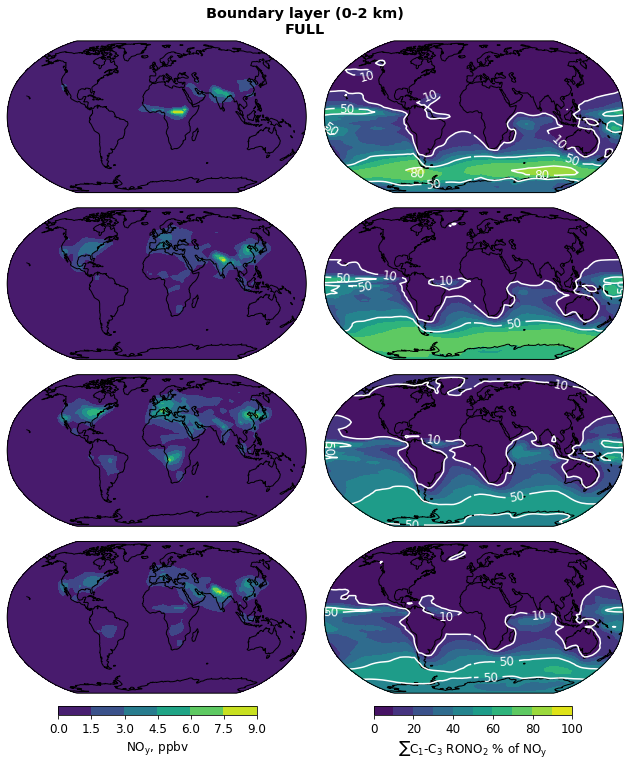

In [12]:
if w_rono2:
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,12), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
    p00 = ax[0,0].contourf(cyclic_lons, lats, cyc_sens_pbl_djf_mean.data, transform=ccrs.PlateCarree())
    ax[1,0].contourf(cyclic_lons, lats, cyc_sens_pbl_mam_mean.data, transform=ccrs.PlateCarree())
    ax[2,0].contourf(cyclic_lons, lats, cyc_sens_pbl_jja_mean.data, transform=ccrs.PlateCarree())
    ax[3,0].contourf(cyclic_lons, lats, cyc_sens_pbl_son_mean.data, transform=ccrs.PlateCarree())

    p01 = ax[0,1].contourf(cyclic_lons, lats, cyc_rno3_pbl_djf_mean.data*100/cyc_sens_pbl_djf_mean.data, transform=ccrs.PlateCarree(), levels=np.arange(0,110,10))
    ax[1,1].contourf(cyclic_lons, lats, cyc_rno3_pbl_mam_mean.data*100/cyc_sens_pbl_mam_mean.data, transform=ccrs.PlateCarree(), levels=np.arange(0,110,10))
    ax[2,1].contourf(cyclic_lons, lats, cyc_rno3_pbl_jja_mean.data*100/cyc_sens_pbl_jja_mean.data, transform=ccrs.PlateCarree(), levels=np.arange(0,110,10))
    ax[3,1].contourf(cyclic_lons, lats, cyc_rno3_pbl_son_mean.data*100/cyc_sens_pbl_son_mean.data, transform=ccrs.PlateCarree(), levels=np.arange(0,110,10))

    p01x = ax[0,1].contour(lons, lats, rno3_pbl_djf_mean.data*100/sens_pbl_djf_mean.data, transform=ccrs.PlateCarree(), levels=[10,50,80], colors='w')
    p11x = ax[1,1].contour(lons, lats, rno3_pbl_mam_mean.data*100/sens_pbl_mam_mean.data, transform=ccrs.PlateCarree(), levels=[10,50,80], colors='w')
    p21x = ax[2,1].contour(lons, lats, rno3_pbl_jja_mean.data*100/sens_pbl_jja_mean.data, transform=ccrs.PlateCarree(), levels=[10,50,80], colors='w')
    p31x = ax[3,1].contour(lons, lats, rno3_pbl_son_mean.data*100/sens_pbl_son_mean.data, transform=ccrs.PlateCarree(), levels=[10,50,80], colors='w')
    ax[0,1].clabel(p01x, inline=1, fmt='%1.0f')
    ax[1,1].clabel(p11x, inline=1, fmt='%1.0f')
    ax[2,1].clabel(p21x, inline=1, fmt='%1.0f')
    ax[3,1].clabel(p31x, inline=1, fmt='%1.0f')

    fig.subplots_adjust(hspace=0.1, wspace=-0.1)
    cax00 = fig.add_axes([0.215, 0.1, 0.23, 0.01])
    fig.colorbar(p00, cax=cax00, orientation='horizontal', label='$NO_y$, ppbv')
    cax01 = fig.add_axes([0.58, 0.1, 0.23, 0.01])
    fig.colorbar(p01, cax=cax01, orientation='horizontal', label='$\sum$$C_1$-$C_3$ $RONO_2$ % of $NO_y$')
    fig.suptitle(f'Boundary layer (0-2 km)\n{sens_exp}', y=0.92, weight='bold')
    for iax in ax.flatten(): iax.coastlines(color='k')

### Zonal seasonal means

In [13]:
# Calculate zonal mean for each month
base_znl_mean = base[:,0:23,...].collapsed('longitude', iris.analysis.MEAN)
sens_znl_mean = sens[:,0:23,...].collapsed('longitude', iris.analysis.MEAN)
# Extract time series of zonal seasonal means
base_znl_djf = base_znl_mean.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
sens_znl_djf = sens_znl_mean.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
base_znl_mam = base_znl_mean.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
sens_znl_mam = sens_znl_mean.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
base_znl_jja = base_znl_mean.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
sens_znl_jja = sens_znl_mean.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
base_znl_son = base_znl_mean.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
sens_znl_son = sens_znl_mean.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
# Check if zonal seasonal mean differences between two experiments are normally distributed using the Shapiro–Wilk test
shapiro_znl_djf_p = np.empty([nlevs,nlats])
shapiro_znl_mam_p = np.empty([nlevs,nlats])
shapiro_znl_jja_p = np.empty([nlevs,nlats])
shapiro_znl_son_p = np.empty([nlevs,nlats])
for i, lev in enumerate(base.coord('level_height')[0:23].points):
    for j, lat in enumerate(base.coord('latitude').points):
        shapiro_znl_djf_p[i,j] = stats.shapiro(base_znl_djf.data[:,i,j] - sens_znl_djf.data[:,i,j])[1]
        shapiro_znl_mam_p[i,j] = stats.shapiro(base_znl_mam.data[:,i,j] - sens_znl_mam.data[:,i,j])[1]
        shapiro_znl_jja_p[i,j] = stats.shapiro(base_znl_jja.data[:,i,j] - sens_znl_jja.data[:,i,j])[1]
        shapiro_znl_son_p[i,j] = stats.shapiro(base_znl_son.data[:,i,j] - sens_znl_son.data[:,i,j])[1]
# See if zonal seasonal mean differences between two experiments are statitically significant using
# (a) paired sample t-test if data is normally distributed, and
# (b) Wilcoxon signed-rank test if data is not normally distributed
znl_djf_p = np.empty([nlevs,nlats])
znl_mam_p = np.empty([nlevs,nlats])
znl_jja_p = np.empty([nlevs,nlats])
znl_son_p = np.empty([nlevs,nlats])
for i, lev in enumerate(base.coord('level_height')[0:23].points):
    for j, lat in enumerate(base.coord('latitude').points):
        if shapiro_znl_djf_p[i,j] > 0.05:
            znl_djf_p[i,j] = stats.ttest_rel(base_znl_djf.data[:,i,j], sens_znl_djf.data[:,i,j])[1]
        else: 
            znl_djf_p[i,j] = stats.wilcoxon(base_znl_djf.data[:,i,j], sens_znl_djf.data[:,i,j])[1]
        if shapiro_znl_mam_p[i,j] > 0.05:
            znl_mam_p[i,j] = stats.ttest_rel(base_znl_mam.data[:,i,j], sens_znl_mam.data[:,i,j])[1]
        else:
            znl_mam_p[i,j] = stats.wilcoxon(base_znl_mam.data[:,i,j], sens_znl_mam.data[:,i,j])[1]
        if shapiro_znl_jja_p[i,j] > 0.05:
            znl_jja_p[i,j] = stats.ttest_rel(base_znl_jja.data[:,i,j], sens_znl_jja.data[:,i,j])[1]
        else:
            znl_jja_p[i,j] = stats.wilcoxon(base_znl_jja.data[:,i,j], sens_znl_jja.data[:,i,j])[1]
        if shapiro_znl_son_p[i,j] > 0.05:
            znl_son_p[i,j] = stats.ttest_rel(base_znl_son.data[:,i,j], sens_znl_son.data[:,i,j])[1]
        else:
            znl_son_p[i,j] = stats.wilcoxon(base_znl_son.data[:,i,j], sens_znl_son.data[:,i,j])[1]
# Calculate zonal seasonal mean differences
base_znl_djf_mean = base_znl_djf.collapsed('year', iris.analysis.MEAN)
base_znl_mam_mean = base_znl_mam.collapsed('year', iris.analysis.MEAN)
base_znl_jja_mean = base_znl_jja.collapsed('year', iris.analysis.MEAN)
base_znl_son_mean = base_znl_son.collapsed('year', iris.analysis.MEAN)
sens_znl_djf_mean = sens_znl_djf.collapsed('year', iris.analysis.MEAN)
sens_znl_mam_mean = sens_znl_mam.collapsed('year', iris.analysis.MEAN)
sens_znl_jja_mean = sens_znl_jja.collapsed('year', iris.analysis.MEAN)
sens_znl_son_mean = sens_znl_son.collapsed('year', iris.analysis.MEAN)
znl_djf_diff = sens_znl_djf_mean - base_znl_djf_mean
znl_mam_diff = sens_znl_mam_mean - base_znl_mam_mean
znl_jja_diff = sens_znl_jja_mean - base_znl_jja_mean
znl_son_diff = sens_znl_son_mean - base_znl_son_mean
# Find max zonal seasonal mean
print(max(np.max(base_znl_djf_mean.data), np.max(sens_znl_djf_mean.data)))
print(max(np.max(base_znl_mam_mean.data), np.max(sens_znl_mam_mean.data)))
print(max(np.max(base_znl_jja_mean.data), np.max(sens_znl_jja_mean.data)))
print(max(np.max(base_znl_son_mean.data), np.max(sens_znl_son_mean.data)))
# Check for false discovery
print('FDR: ', fdr_threshold(znl_djf_p), fdr_threshold(znl_mam_p), fdr_threshold(znl_jja_p), fdr_threshold(znl_son_p))

/local/mwe14avu/miniconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


1.0858202477296195
1.1638031601905823
1.6601046919822693
1.2575127283732095
FDR:  0.05515039051308593 0.07579562119399044 0.08598145311141674 0.07104373877612884


- CHEM-BASE O3: 239.92675399780273 304.44007619222003 220.81518999735516 200.28447914123535 FDR:  0.0 0.0 0.0 0.0
- MARI-BASE O3: 256.53899574279785 312.3972810109457 228.8615900675456 201.7245871225993 FDR:  0.015697085783157084 0.0 0.0 0.02324822896113234
- FULL-BASE O3: 246.73359489440918 297.44246101379395 225.37927500406903 200.35796419779462 FDR:  0.028341324207195196 0.0 0.013296548807684348 0.019616658169879304
- CHEM-BASE NOy w RONO2: 1.0860120157400766 1.1680093606313071 1.6296287775039673 1.2575127283732095 FDR:  0.03138079931446896 0.047629546620460914 0.04852924508823632 0.046267120071516954
- MARI-BASE NOy w RONO2: 1.0858202477296195 1.1660320361455283 1.670572822292646 1.2719601790110269 FDR:  0.03040812441092543 0.04057126632061856 0.04545631866899116 0.0394323523805973
- FULL-BASE NOy w RONO2: 1.0858202477296195 1.1638031601905823 1.6601046919822693 1.2575127283732095 FDR:  0.05515039051308593 0.07579562119399044 0.08598145311141674 0.07104373877612884


- FULL-BASE NOy wo RONO2: 1.0858202477296195 1.1514161676168442 1.6382570316394172 1.2575127283732095 FDR:  0.016272175817194517 0.0 0.0 0.016019524727490988

In [14]:
# Zonal seasonal mean plotting parameters
if var == 'o3':
    znl_mean_cf_kwargs = dict(levels=np.arange(0,130,10), extend='max')
elif var == 'noy':
    znl_mean_cf_kwargs = dict(levels=np.arange(0,2,0.2))
znl_mean_pc_kwargs = dict(cmap='RdBu_r')
znl_mean_cr_kwargs = dict(levels=[-10,-5,0,5,10], cmap='RdBu_r')
znl_pval_kwargs = dict(s=5, c='k', marker='.', alpha=1)
fdr_znl = True # turn FDR on/off
def stipple_zonal(cube, pval_arr, fdr):
    '''Stipple areas where p-values are statistically significant. 
    Inspired by https://groups.google.com/forum/#!topic/scitools-iris/Xm2IhQ6YKQA'''
    xOrg = cube.coord('latitude').points 
    yOrg = cube.coord('level_height').points
    nlon = len(xOrg) 
    nlat = len(yOrg) 
    xData = np.reshape( np.tile(xOrg, nlat), pval_arr.shape ) 
    yData = np.reshape( np.repeat(yOrg, nlon), pval_arr.shape )
    if fdr:
        thresh = fdr_threshold(pval_arr) # false discovery rate threshold
    else:
        thresh = 0.05
    sigPoints = pval_arr < thresh 
    xPoints = xData[sigPoints]
    yPoints = yData[sigPoints]
    return (xPoints, yPoints)
lats = base.coord('latitude').points
levs = base.coord('level_height').points[0:23]

In [15]:
# Find min and max absolute zonal seasonal mean difference
print(min([np.min(znl_djf_diff.data), np.min(znl_mam_diff.data), np.min(znl_jja_diff.data), np.min(znl_son_diff.data)]))
print(max([np.max(znl_djf_diff.data), np.max(znl_mam_diff.data), np.max(znl_jja_diff.data), np.max(znl_son_diff.data)]))
# Find min and max % zonal seasonal mean difference
print(min([np.min(znl_djf_diff.data/base_znl_djf_mean.data*100), np.min(znl_mam_diff.data/base_znl_mam_mean.data*100), 
           np.min(znl_jja_diff.data/base_znl_jja_mean.data*100), np.min(znl_son_diff.data/base_znl_son_mean.data*100)]))
print(max([np.max(znl_djf_diff.data/base_znl_djf_mean.data*100), np.max(znl_mam_diff.data/base_znl_mam_mean.data*100), 
           np.max(znl_jja_diff.data/base_znl_jja_mean.data*100), np.max(znl_son_diff.data/base_znl_son_mean.data*100)]))

-0.058240221192439434
0.07530604799588536
-12.41017950191274
753.3187754558724


- CHEM-BASE O3: -11.705768585205078 36.959577560424805 -7.1608906130925405 15.344309728289055
- MARI-BASE O3: -2.884126663208008 45.04723739624029 -3.704269622045892 20.246400682614734
- FULL-BASE O3: -10.710908253987611 33.24661191304523 -5.8698472778794555 19.024541231085976
- CHEM-BASE NOy w RONO2: -0.06400503218173981 0.04748198886712385 -13.731033471996446 46.23153934451011
- MARI-BASE NOy w RONO2: -0.04005942493677139 0.06000681594014168 -10.844401412985377 714.103718245858
- FULL-BASE NOy w RONO2: -0.058240221192439434 0.07530604799588536 -12.41017950191274 753.3187754558724


- FULL-BASE NOy wo RONO2: -0.0684942019482454 0.05248606950044632 -15.602732055084134 64.173010955936

In [16]:
# Additional plotting parameters for zonal seasonal mean summary
if var == 'o3':
    znl_glb_absdiff_pc_kwargs = dict(cmap='RdBu_r', levels=np.arange(-3,4,1), extend='both')
    znl_glb_pctdiff_pc_kwargs = dict(cmap='RdBu_r', levels=np.arange(-25,30,5))
elif var == 'noy':
    znl_glb_absdiff_pc_kwargs = dict(cmap='RdBu_r', levels=np.arange(-0.08,0.1,0.02))
    znl_glb_pctdiff_pc_kwargs = dict(cmap='RdBu_r', levels=np.arange(-70,80,10), extend='max')

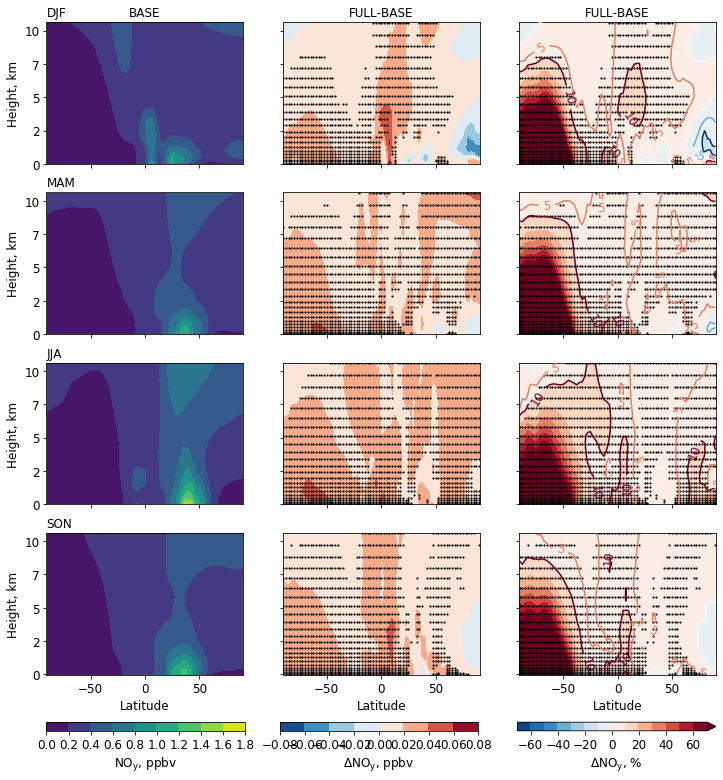

In [17]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12,12), facecolor='w', sharex=True, sharey=True)
p00 = ax[0,0].contourf(lats, levs, base_znl_djf_mean.data, **znl_mean_cf_kwargs)
p01 = ax[0,1].contourf(lats, levs, znl_djf_diff.data, **znl_glb_absdiff_pc_kwargs)
p02 = ax[0,2].contourf(lats, levs, znl_djf_diff.data/base_znl_djf_mean.data*100, **znl_glb_pctdiff_pc_kwargs)
p02x = ax[0,2].contour(lats, levs, znl_djf_diff.data/base_znl_djf_mean.data*100, **znl_mean_cr_kwargs)
ax[0,2].clabel(p02x, inline=1, fmt='%1.0f')
# p01.cmap.set_under('w')
# p01.cmap.set_over('w')

ax[1,0].contourf(lats, levs, base_znl_mam_mean.data, **znl_mean_cf_kwargs)
ax[1,1].contourf(lats, levs, znl_mam_diff.data, **znl_glb_absdiff_pc_kwargs)
ax[1,2].contourf(lats, levs, znl_mam_diff.data/base_znl_mam_mean.data*100, **znl_glb_pctdiff_pc_kwargs)
p12x = ax[1,2].contour(lats, levs, znl_mam_diff.data/base_znl_mam_mean.data*100, **znl_mean_cr_kwargs)
ax[1,2].clabel(p12x, inline=1, fmt='%1.0f')

ax[2,0].contourf(lats, levs, base_znl_jja_mean.data, **znl_mean_cf_kwargs)
ax[2,1].contourf(lats, levs, znl_jja_diff.data, **znl_glb_absdiff_pc_kwargs)
ax[2,2].contourf(lats, levs, znl_jja_diff.data/base_znl_jja_mean.data*100, **znl_glb_pctdiff_pc_kwargs)
p22x = ax[2,2].contour(lats, levs, znl_jja_diff.data/base_znl_jja_mean.data*100, **znl_mean_cr_kwargs)
ax[2,2].clabel(p22x, inline=1, fmt='%1.0f')

p30 = ax[3,0].contourf(lats, levs, base_znl_son_mean.data, **znl_mean_cf_kwargs)
p31 = ax[3,1].contourf(lats, levs, znl_son_diff.data, **znl_glb_absdiff_pc_kwargs)
p32 = ax[3,2].contourf(lats, levs, znl_son_diff.data/base_znl_son_mean.data*100, **znl_glb_pctdiff_pc_kwargs)
p32x = ax[3,2].contour(lats, levs, znl_son_diff.data/base_znl_son_mean.data*100, **znl_mean_cr_kwargs)
ax[3,2].clabel(p32x, inline=1, fmt='%1.0f')

cax0 = fig.add_axes([0.125, 0.06, 0.23, 0.01])
cax1 = fig.add_axes([0.395, 0.06, 0.23, 0.01])
cax2 = fig.add_axes([0.670, 0.06, 0.23, 0.01])
fig.colorbar(p30, cax=cax0, orientation='horizontal', label=var_dict['str'][var]+', ppbv')
fig.colorbar(p31, cax=cax1, orientation='horizontal', label='$\Delta$'+var_dict['str'][var]+', ppbv')#, format=FuncFormatter(custom_ctcklbls))
fig.colorbar(p32, cax=cax2, orientation='horizontal', label='$\Delta$'+var_dict['str'][var]+', %')
ax[0,0].set_title(f'{base_exp}', loc='center')
ax[0,1].set_title(f'{sens_exp}-{base_exp}', loc='center')
ax[0,2].set_title(f'{sens_exp}-{base_exp}', loc='center')
ax[0,0].set_title('DJF', loc='left')
ax[1,0].set_title('MAM', loc='left')
ax[2,0].set_title('JJA', loc='left')
ax[3,0].set_title('SON', loc='left')
for iax in ax[:,0].flatten(): iax.set_ylabel('Height, km')
for iax in ax[3,:].flatten(): iax.set_xlabel('Latitude')
for iax in ax.flatten():
    iax.margins(x=0, y=0)
    iax.yaxis.set_major_formatter(FuncFormatter(m2km))
for iax in ax[0,1:3].flatten(): iax.scatter(*stipple_zonal(znl_djf_diff, znl_djf_p, fdr_znl), **znl_pval_kwargs)
for iax in ax[1,1:3].flatten(): iax.scatter(*stipple_zonal(znl_mam_diff, znl_mam_p, fdr_znl), **znl_pval_kwargs)
for iax in ax[2,1:3].flatten(): iax.scatter(*stipple_zonal(znl_jja_diff, znl_jja_p, fdr_znl), **znl_pval_kwargs)
for iax in ax[3,1:3].flatten(): iax.scatter(*stipple_zonal(znl_son_diff, znl_son_p, fdr_znl), **znl_pval_kwargs)
if savefig: fig.savefig(path_to_figs / f'{var}_znl_ssn_mean.png', bbox_inches='tight', dpi=300)

In [ ]:
break

### Free troposphere seasonal means

In [ ]:
# Find 5-10 km level height range
base.coord('level_height')[15:23].points/1000

In [ ]:
# Extract time series of free troposphere (5-10 km) seasonal means
base_fre_djf = (base.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,15:23,...]).collapsed('level_height', iris.analysis.MEAN)
sens_fre_djf = (sens.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,15:23,...]).collapsed('level_height', iris.analysis.MEAN)
base_fre_mam = (base.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,15:23,...]).collapsed('level_height', iris.analysis.MEAN)
sens_fre_mam = (sens.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,15:23,...]).collapsed('level_height', iris.analysis.MEAN)
base_fre_jja = (base.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,15:23,...]).collapsed('level_height', iris.analysis.MEAN)
sens_fre_jja = (sens.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,15:23,...]).collapsed('level_height', iris.analysis.MEAN)
base_fre_son = (base.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,15:23,...]).collapsed('level_height', iris.analysis.MEAN)
sens_fre_son = (sens.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,15:23,...]).collapsed('level_height', iris.analysis.MEAN)
# Check if free troposphere seasonal mean differences between two experiments are normally distributed using the Shapiro–Wilk test
shapiro_fre_djf_p = np.empty([nlats,nlons])
shapiro_fre_mam_p = np.empty([nlats,nlons])
shapiro_fre_jja_p = np.empty([nlats,nlons])
shapiro_fre_son_p = np.empty([nlats,nlons])
for i, lat in enumerate(base.coord('latitude').points):
    for j, lon in enumerate(base.coord('longitude').points):
        shapiro_fre_djf_p[i,j] = stats.shapiro(base_fre_djf.data[:,i,j] - sens_fre_djf.data[:,i,j])[1]
        shapiro_fre_mam_p[i,j] = stats.shapiro(base_fre_mam.data[:,i,j] - sens_fre_mam.data[:,i,j])[1]
        shapiro_fre_jja_p[i,j] = stats.shapiro(base_fre_jja.data[:,i,j] - sens_fre_jja.data[:,i,j])[1]
        shapiro_fre_son_p[i,j] = stats.shapiro(base_fre_son.data[:,i,j] - sens_fre_son.data[:,i,j])[1]
# See if free troposphere seasonal mean differences between two experiments are statitically significant using
# (a) paired sample t-test if data is normally distributed, and
# (b) Wilcoxon signed-rank test if data is not normally distributed
fre_djf_p = np.empty([nlats,nlons])
fre_mam_p = np.empty([nlats,nlons])
fre_jja_p = np.empty([nlats,nlons])
fre_son_p = np.empty([nlats,nlons])
for i, lat in enumerate(base.coord('latitude').points):
    for j, lon in enumerate(base.coord('longitude').points):
        if shapiro_fre_djf_p[i,j] > 0.05:
            fre_djf_p[i,j] = stats.ttest_rel(base_fre_djf.data[:,i,j], sens_fre_djf.data[:,i,j])[1]
        else: 
            fre_djf_p[i,j] = stats.wilcoxon(base_fre_djf.data[:,i,j], sens_fre_djf.data[:,i,j])[1]
        if shapiro_fre_mam_p[i,j] > 0.05:
            fre_mam_p[i,j] = stats.ttest_rel(base_fre_mam.data[:,i,j], sens_fre_mam.data[:,i,j])[1]
        else:
            fre_mam_p[i,j] = stats.wilcoxon(base_fre_mam.data[:,i,j], sens_fre_mam.data[:,i,j])[1]
        if shapiro_fre_jja_p[i,j] > 0.05:
            fre_jja_p[i,j] = stats.ttest_rel(base_fre_jja.data[:,i,j], sens_fre_jja.data[:,i,j])[1]
        else:
            fre_jja_p[i,j] = stats.wilcoxon(base_fre_jja.data[:,i,j], sens_fre_jja.data[:,i,j])[1]
        if shapiro_fre_son_p[i,j] > 0.05:
            fre_son_p[i,j] = stats.ttest_rel(base_fre_son.data[:,i,j], sens_fre_son.data[:,i,j])[1]
        else:
            fre_son_p[i,j] = stats.wilcoxon(base_fre_son.data[:,i,j], sens_fre_son.data[:,i,j])[1]
#         # Welch's t-test
#         fre_djf_p[i, j] = stats.ttest_ind(base_fre_djf.data[:,i,j], sens_fre_djf.data[:,i,j], equal_var=False)[1]
#         fre_mam_p[i, j] = stats.ttest_ind(base_fre_mam.data[:,i,j], sens_fre_mam.data[:,i,j], equal_var=False)[1]
#         fre_jja_p[i, j] = stats.ttest_ind(base_fre_jja.data[:,i,j], sens_fre_jja.data[:,i,j], equal_var=False)[1]
#         fre_son_p[i, j] = stats.ttest_ind(base_fre_son.data[:,i,j], sens_fre_son.data[:,i,j], equal_var=False)[1]
# Calculate free troposphere seasonal mean differences
base_fre_djf_mean = base_fre_djf.collapsed('year', iris.analysis.MEAN)
base_fre_mam_mean = base_fre_mam.collapsed('year', iris.analysis.MEAN)
base_fre_jja_mean = base_fre_jja.collapsed('year', iris.analysis.MEAN)
base_fre_son_mean = base_fre_son.collapsed('year', iris.analysis.MEAN)
sens_fre_djf_mean = sens_fre_djf.collapsed('year', iris.analysis.MEAN)
sens_fre_mam_mean = sens_fre_mam.collapsed('year', iris.analysis.MEAN)
sens_fre_jja_mean = sens_fre_jja.collapsed('year', iris.analysis.MEAN)
sens_fre_son_mean = sens_fre_son.collapsed('year', iris.analysis.MEAN)
fre_djf_diff = sens_fre_djf_mean - base_fre_djf_mean
fre_mam_diff = sens_fre_mam_mean - base_fre_mam_mean
fre_jja_diff = sens_fre_jja_mean - base_fre_jja_mean
fre_son_diff = sens_fre_son_mean - base_fre_son_mean
# Add cyclic point for plotting on a global map
cyc_fre_djf_diff, cyclic_lons = cartopy.util.add_cyclic_point(fre_djf_diff.data, coord=fre_djf_diff.coord('longitude').points)
cyc_fre_mam_diff = cartopy.util.add_cyclic_point(fre_mam_diff.data)
cyc_fre_jja_diff = cartopy.util.add_cyclic_point(fre_jja_diff.data)
cyc_fre_son_diff = cartopy.util.add_cyclic_point(fre_son_diff.data)
cyc_base_fre_djf_mean = cartopy.util.add_cyclic_point(base_fre_djf_mean.data)
cyc_base_fre_mam_mean = cartopy.util.add_cyclic_point(base_fre_mam_mean.data)
cyc_base_fre_jja_mean = cartopy.util.add_cyclic_point(base_fre_jja_mean.data)
cyc_base_fre_son_mean = cartopy.util.add_cyclic_point(base_fre_son_mean.data)
# Find max free troposphere seasonal mean
print(max(np.max(base_fre_djf_mean.data), np.max(sens_fre_djf_mean.data)))
print(max(np.max(base_fre_mam_mean.data), np.max(sens_fre_mam_mean.data)))
print(max(np.max(base_fre_jja_mean.data), np.max(sens_fre_jja_mean.data)))
print(max(np.max(base_fre_son_mean.data), np.max(sens_fre_son_mean.data)))
# Check for false discovery
print('FDR: ', fdr_threshold(fre_djf_p), fdr_threshold(fre_mam_p), fdr_threshold(fre_jja_p), fdr_threshold(fre_son_p))

xojnb: 120.777016
143.42606
103.412575
98.72422
FDR:  0.0 0.0 0.0 0.0

xojnc: 121.10372
143.42606
103.412575
98.65314
FDR:  0.0 0.0 0.0 0.0

xojnh: 120.765015
149.06247
104.27327
98.522446
FDR:  0.0 0.0 0.0 0.0

xojng-xojnd: 114.26029
141.99973
103.587
96.9711
FDR:  0.0 0.0 0.0 0.0

In [ ]:
# Free troposphere seasonal mean difference plotting parameters
fre_mean_cf_kwargs = dict(transform=ccrs.PlateCarree(), levels=np.arange(0,175,25))
fre_diff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r')
fre_pval_sc_kwargs = dict(transform=ccrs.PlateCarree(), s=10, c='k', marker='.', alpha=0.2)
fdr_fre = True # turn FDR on/off
def stipple_fre(cube, pval_arr, fdr, central_long=0):
    '''Stipple areas where p-values are statistically significant. 
    Inspired by https://groups.google.com/forum/#!topic/scitools-iris/Xm2IhQ6YKQA'''
    xOrg = cube.coord('longitude').points 
    yOrg = cube.coord('latitude').points
    nlon = len(xOrg) 
    nlat = len(yOrg) 
    xData = np.reshape( np.tile(xOrg, nlat), pval_arr.shape ) 
    yData = np.reshape( np.repeat(yOrg, nlon), pval_arr.shape )
    if fdr:
        thresh = fdr_threshold(pval_arr) # false discovery rate threshold
    else:
        thresh=0.05
    sigPoints = pval_arr < thresh 
    xPoints = xData[sigPoints] - central_long
    yPoints = yData[sigPoints]
    return (xPoints, yPoints)

In [ ]:
# Find min and max absolute free troposphere seasonal mean difference
print(min([np.min(cyc_fre_djf_diff.data), np.min(cyc_fre_mam_diff.data), np.min(cyc_fre_jja_diff.data), np.min(cyc_fre_son_diff.data)]))
print(max([np.max(cyc_fre_djf_diff.data), np.max(cyc_fre_mam_diff.data), np.max(cyc_fre_jja_diff.data), np.max(cyc_fre_son_diff.data)]))
# Find min and max % free troposphere seasonal mean difference
print(min([np.min(cyc_fre_djf_diff.data/cyc_base_fre_djf_mean.data*100), np.min(cyc_fre_mam_diff.data/cyc_base_fre_mam_mean.data*100), 
           np.min(cyc_fre_jja_diff.data/cyc_base_fre_jja_mean.data*100), np.min(cyc_fre_son_diff.data/cyc_base_fre_son_mean.data*100)]))
print(max([np.max(cyc_fre_djf_diff.data/cyc_base_fre_djf_mean.data*100), np.max(cyc_fre_mam_diff.data/cyc_base_fre_mam_mean.data*100), 
           np.max(cyc_fre_jja_diff.data/cyc_base_fre_jja_mean.data*100), np.max(cyc_fre_son_diff.data/cyc_base_fre_son_mean.data*100)]))

xojnb: -6.1123123
9.220947
-12.65836
11.857278

xojnc: -7.031479
11.983612
-10.37066
12.530851

xojnh: -7.2104187
21.54293
-13.351525
22.34018

xojng-xojnd: -11.205681
10.285858
-12.337628
12.704867

In [ ]:
# Additional plotting parameteres for free troposphere seasonal mean summary
fre_glb_absdiff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.arange(-12,14,2))
fre_glb_pctdiff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.arange(-14,16,2))#, extend='both')

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12,12), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
ax[0,0].contourf(cyclic_lons, lats, cyc_base_fre_djf_mean.data, **fre_mean_cf_kwargs)
ax[0,1].contourf(cyclic_lons, lats, cyc_fre_djf_diff.data, **fre_glb_absdiff_cf_kwargs)
ax[0,2].contourf(cyclic_lons, lats, cyc_fre_djf_diff.data/cyc_base_fre_djf_mean.data*100, **fre_glb_pctdiff_cf_kwargs)

ax[1,0].contourf(cyclic_lons, lats, cyc_base_fre_mam_mean.data, **fre_mean_cf_kwargs)
ax[1,1].contourf(cyclic_lons, lats, cyc_fre_mam_diff.data, **fre_glb_absdiff_cf_kwargs)
ax[1,2].contourf(cyclic_lons, lats, cyc_fre_mam_diff.data/cyc_base_fre_mam_mean.data*100, **fre_glb_pctdiff_cf_kwargs)

ax[2,0].contourf(cyclic_lons, lats, cyc_base_fre_jja_mean.data, **fre_mean_cf_kwargs)
ax[2,1].contourf(cyclic_lons, lats, cyc_fre_jja_diff.data, **fre_glb_absdiff_cf_kwargs)
ax[2,2].contourf(cyclic_lons, lats, cyc_fre_jja_diff.data/cyc_base_fre_jja_mean.data*100, **fre_glb_pctdiff_cf_kwargs)

p30 = ax[3,0].contourf(cyclic_lons, lats, cyc_base_fre_son_mean.data, **fre_mean_cf_kwargs)
p31 = ax[3,1].contourf(cyclic_lons, lats, cyc_fre_son_diff.data, **fre_glb_absdiff_cf_kwargs)
p32 = ax[3,2].contourf(cyclic_lons, lats, cyc_fre_son_diff.data/cyc_base_fre_son_mean.data*100, **fre_glb_pctdiff_cf_kwargs)

fig.subplots_adjust(hspace=-0.8, wspace=-0.5)
fig.tight_layout()
cax0 = fig.add_axes([0.02, 0.12, 0.3, 0.01])
cax1 = fig.add_axes([0.35, 0.12, 0.3, 0.01])
cax2 = fig.add_axes([0.68, 0.12, 0.3, 0.01])
fig.colorbar(p30, cax=cax0, orientation='horizontal', label=f'{str_var}, ppbv')
fig.colorbar(p31, cax=cax1, orientation='horizontal', label=f'$\Delta${str_var}, ppbv')
fig.colorbar(p32, cax=cax2, orientation='horizontal', label=f'$\Delta${str_var}, %')
fig.text(0.02, 0.84, 'DJF')#, fontsize=12)
fig.text(0.02, 0.66, 'MAM')#, fontsize=12)
fig.text(0.02, 0.48, 'JJA')#, fontsize=12)
fig.text(0.02, 0.31, 'SON')#, fontsize=12)
fig.suptitle('Free troposphere (5-10 km)', y=0.9, weight='bold')
ax[0,0].set_title(f'{base_exp}')
ax[0,1].set_title(f'{sens_exp}-{base_exp}')
ax[0,2].set_title(f'{sens_exp}-{base_exp}')
for iax in ax[0,1:3].flatten(): iax.scatter(*stipple_fre(fre_djf_diff, fre_djf_p, fdr_fre), **fre_pval_sc_kwargs)
for iax in ax[1,1:3].flatten(): iax.scatter(*stipple_fre(fre_mam_diff, fre_mam_p, fdr_fre), **fre_pval_sc_kwargs)
for iax in ax[2,1:3].flatten(): iax.scatter(*stipple_fre(fre_jja_diff, fre_jja_p, fdr_fre), **fre_pval_sc_kwargs)
for iax in ax[3,1:3].flatten(): iax.scatter(*stipple_fre(fre_son_diff, fre_son_p, fdr_fre), **fre_pval_sc_kwargs)
for iax in ax.flatten(): iax.set_global()
for iax in ax[:,0].flatten(): iax.coastlines(color='k')
for iax in ax[0:4,1:].flatten(): iax.coastlines(color='grey')
if savefig: fig.savefig(path_to_figs / f'{dir_var}_fre_seas_mean_all.png', bbox_inches='tight')

In [ ]:
break

In [ ]:
# Plot boundary layer seasonal mean using 3 columns
# fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12,12), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
# ax[0,0].contourf(cyclic_lons, lats, cyc_base_srf_djf_mean.data, **srf_mean_cf_kwargs)
# ax[0,1].contourf(cyclic_lons, lats, cyc_srf_djf_diff.data, **srf_glb_absdiff_cf_kwargs)
# ax[0,2].contourf(cyclic_lons, lats, cyc_srf_djf_diff.data/cyc_base_srf_djf_mean.data*100, **srf_glb_pctdiff_cf_kwargs)

# ax[1,0].contourf(cyclic_lons, lats, cyc_base_srf_mam_mean.data, **srf_mean_cf_kwargs)
# ax[1,1].contourf(cyclic_lons, lats, cyc_srf_mam_diff.data, **srf_glb_absdiff_cf_kwargs)
# ax[1,2].contourf(cyclic_lons, lats, cyc_srf_mam_diff.data/cyc_base_srf_mam_mean.data*100, **srf_glb_pctdiff_cf_kwargs)

# ax[2,0].contourf(cyclic_lons, lats, cyc_base_srf_jja_mean.data, **srf_mean_cf_kwargs)
# ax[2,1].contourf(cyclic_lons, lats, cyc_srf_jja_diff.data, **srf_glb_absdiff_cf_kwargs)
# ax[2,2].contourf(cyclic_lons, lats, cyc_srf_jja_diff.data/cyc_base_srf_jja_mean.data*100, **srf_glb_pctdiff_cf_kwargs)

# p30 = ax[3,0].contourf(cyclic_lons, lats, cyc_base_srf_son_mean.data, **srf_mean_cf_kwargs)
# p31 = ax[3,1].contourf(cyclic_lons, lats, cyc_srf_son_diff.data, **srf_glb_absdiff_cf_kwargs)
# p32 = ax[3,2].contourf(cyclic_lons, lats, cyc_srf_son_diff.data/cyc_base_srf_son_mean.data*100, **srf_glb_pctdiff_cf_kwargs)

# fig.subplots_adjust(hspace=-0.8, wspace=-0.5)
# fig.tight_layout()
# cax0 = fig.add_axes([0.02, 0.12, 0.3, 0.01])
# cax1 = fig.add_axes([0.35, 0.12, 0.3, 0.01])
# cax2 = fig.add_axes([0.68, 0.12, 0.3, 0.01])
# fig.colorbar(p30, cax=cax0, orientation='horizontal', label=f'{str_var}, ppbv')
# fig.colorbar(p31, cax=cax1, orientation='horizontal', label=f'$\Delta${str_var}, ppbv')
# fig.colorbar(p32, cax=cax2, orientation='horizontal', label=f'$\Delta${str_var}, %')
# fig.text(0.02, 0.84, 'DJF')#, fontsize=12)
# fig.text(0.02, 0.66, 'MAM')#, fontsize=12)
# fig.text(0.02, 0.48, 'JJA')#, fontsize=12)
# fig.text(0.02, 0.31, 'SON')#, fontsize=12)
# fig.suptitle('Surface', y=0.9, weight='bold')
# ax[0,0].set_title(f'{base_plt}')
# ax[0,1].set_title(f'{sens_plt}-{base_plt}')
# ax[0,2].set_title(f'{sens_plt}-{base_plt}')
# for iax in ax[0,1:3].flatten(): iax.scatter(*stipple_srf(srf_djf_diff, srf_djf_p, fdr_srf), **srf_pval_sc_kwargs)
# for iax in ax[1,1:3].flatten(): iax.scatter(*stipple_srf(srf_mam_diff, srf_mam_p, fdr_srf), **srf_pval_sc_kwargs)
# for iax in ax[2,1:3].flatten(): iax.scatter(*stipple_srf(srf_jja_diff, srf_jja_p, fdr_srf), **srf_pval_sc_kwargs)
# for iax in ax[3,1:3].flatten(): iax.scatter(*stipple_srf(srf_son_diff, srf_son_p, fdr_srf), **srf_pval_sc_kwargs)
# for iax in ax.flatten(): iax.set_global()
# for iax in ax[:,0].flatten(): iax.coastlines(color='k')
# for iax in ax[0:4,1:].flatten(): iax.coastlines(color='grey')
# if savefig: fig.savefig(path_to_figs / f'{dir_var}_srf_seas_mean_all.png', bbox_inches='tight')

In [ ]:
# Plot zonal mean bigger picture
# fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20,20), facecolor='w', sharex=True, sharey=True)
# p00 = ax[0,0].contourf(lats, levs, base_znl_djf_mean.data, **znl_mean_cf_kwargs)
# p01 = ax[0,1].contourf(lats, levs, znl_djf_diff.data, **znl_glb_absdiff_pc_kwargs)
# p02 = ax[0,2].contourf(lats, levs, znl_djf_diff.data/base_znl_djf_mean.data*100, **znl_glb_pctdiff_pc_kwargs)
# p02x = ax[0,2].contour(lats, levs, znl_djf_diff.data/base_znl_djf_mean.data*100, **znl_mean_cr_kwargs)
# ax[0,2].clabel(p02x, inline=1, fmt='%1.0f')
# p01.cmap.set_under('w')
# p01.cmap.set_over('w')

# ax[1,0].contourf(lats, levs, base_znl_mam_mean.data, **znl_mean_cf_kwargs)
# ax[1,1].contourf(lats, levs, znl_mam_diff.data, **znl_glb_absdiff_pc_kwargs)
# ax[1,2].contourf(lats, levs, znl_mam_diff.data/base_znl_mam_mean.data*100, **znl_glb_pctdiff_pc_kwargs)
# p12x = ax[1,2].contour(lats, levs, znl_mam_diff.data/base_znl_mam_mean.data*100, **znl_mean_cr_kwargs)
# ax[1,2].clabel(p12x, inline=1, fmt='%1.0f')

# ax[2,0].contourf(lats, levs, base_znl_jja_mean.data, **znl_mean_cf_kwargs)
# ax[2,1].contourf(lats, levs, znl_jja_diff.data, **znl_glb_absdiff_pc_kwargs)
# ax[2,2].contourf(lats, levs, znl_jja_diff.data/base_znl_jja_mean.data*100, **znl_glb_pctdiff_pc_kwargs)
# p22x = ax[2,2].contour(lats, levs, znl_jja_diff.data/base_znl_jja_mean.data*100, **znl_mean_cr_kwargs)
# ax[2,2].clabel(p22x, inline=1, fmt='%1.0f')

# p30 = ax[3,0].contourf(lats, levs, base_znl_son_mean.data, **znl_mean_cf_kwargs)
# p31 = ax[3,1].contourf(lats, levs, znl_son_diff.data, **znl_glb_absdiff_pc_kwargs)
# p32 = ax[3,2].contourf(lats, levs, znl_son_diff.data/base_znl_son_mean.data*100, **znl_glb_pctdiff_pc_kwargs)
# p32x = ax[3,2].contour(lats, levs, znl_son_diff.data/base_znl_son_mean.data*100, **znl_mean_cr_kwargs)
# ax[3,2].clabel(p32x, inline=1, fmt='%1.0f')

# cax0 = fig.add_axes([0.139, 0.06, 0.2, 0.01]) # 0.07 for bottom when not for presentation
# cax1 = fig.add_axes([0.412, 0.06, 0.2, 0.01])
# cax2 = fig.add_axes([0.686, 0.06, 0.2, 0.01])
# fig.colorbar(p30, cax=cax0, orientation='horizontal', label=var_dict['str'][var]+', ppbv')
# fig.colorbar(p31, cax=cax1, orientation='horizontal', label='$\Delta$'+var_dict['str'][var]+', ppbv')#, format=FuncFormatter(custom_ctcklbls))
# fig.colorbar(p32, cax=cax2, orientation='horizontal', label='$\Delta$'+var_dict['str'][var]+', %')
# ax[0,0].set_title(f'{base_exp}', loc='center')
# ax[0,1].set_title(f'{sens_exp}-{base_exp}', loc='center')
# ax[0,2].set_title(f'{sens_exp}-{base_exp}', loc='center')
# ax[0,0].set_title(f'{str_djf}', loc='left')
# ax[1,0].set_title(f'{str_mam}', loc='left')
# ax[2,0].set_title(f'{str_jja}', loc='left')
# ax[3,0].set_title(f'{str_son}', loc='left')
# for iax in ax[:,0].flatten(): iax.set_ylabel('Height, km')
# for iax in ax[3,:].flatten(): iax.set_xlabel('Latitude')
# for iax in ax.flatten():
#     iax.margins(x=0, y=0)
#     iax.yaxis.set_major_formatter(FuncFormatter(m2km))
# for iax in ax[0,1:3].flatten(): iax.scatter(*stipple_zonal(znl_djf_diff, znl_djf_p, fdr_znl), **znl_pval_kwargs)
# for iax in ax[1,1:3].flatten(): iax.scatter(*stipple_zonal(znl_mam_diff, znl_mam_p, fdr_znl), **znl_pval_kwargs)
# for iax in ax[2,1:3].flatten(): iax.scatter(*stipple_zonal(znl_jja_diff, znl_jja_p, fdr_znl), **znl_pval_kwargs)
# for iax in ax[3,1:3].flatten(): iax.scatter(*stipple_zonal(znl_son_diff, znl_son_p, fdr_znl), **znl_pval_kwargs)
# # if savefig: fig.savefig(path_to_figs / f'{var}_znl_ssn_mean_all_publ.png', bbox_inches='tight')

In [ ]:
# def plt_pbl_ssn_mean(cyc_base_pbl_ssn_mean, cyc_pbl_ssn_diff, pbl_ssn_diff, pbl_ssn_p, str_ssn):
#     '''Plot boundary layer seasonal mean for a single season. Use: plt_pbl_ssn_mean(cyc_base_pbl_djf_mean, cyc_pbl_djf_diff, pbl_djf_diff, pbl_djf_p, str_djf)'''
#     fig, ax = plt.subplots(ncols=3, figsize=(18,6), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
#     p00 = ax[0].contourf(cyclic_lons, lats, cyc_base_pbl_ssn_mean.data, **pbl_mean_cf_kwargs)
#     p01 = ax[1].contourf(cyclic_lons, lats, cyc_pbl_ssn_diff.data, norm=MidpointNormalize(midpoint=0.), **pbl_diff_cf_kwargs)
#     p02 = ax[2].contourf(cyclic_lons, lats, cyc_pbl_ssn_diff.data/cyc_base_pbl_ssn_mean.data*100, norm=MidpointNormalize(midpoint=0.), **pbl_diff_cf_kwargs)
#     ax[0].set_title(f'{str_ssn}', loc='right')
#     ax[1].set_title(f'{str_ssn}', loc='right')
#     ax[2].set_title(f'{str_ssn}', loc='right')
#     ax[0].set_title(f'{str_var}', loc='center')
#     ax[1].set_title(f'$\Delta${str_var}', loc='center')
#     ax[2].set_title(f'$\Delta${str_var}', loc='center')
#     ax[0].set_title(f'{base_exp}', loc='left')
#     ax[1].set_title(f'{sens_exp}-{base_exp}', loc='left')
#     ax[2].set_title(f'{sens_exp}-{base_exp}', loc='left')
#     cb00 = fig.colorbar(p00, ax=ax[0], shrink=0.3)
#     cb01 = fig.colorbar(p01, ax=ax[1], shrink=0.3)
#     cb02 = fig.colorbar(p02, ax=ax[2], shrink=0.3)
#     cb00.ax.set_title('ppbv', pad=10, loc='left')
#     cb01.ax.set_title('ppbv', pad=10, loc='left')
#     cb02.ax.set_title('%', pad=10, loc='left')
#     for iax in ax.flatten()[1:3]: iax.scatter(*stipple_pbl(pbl_ssn_diff, pbl_ssn_p, fdr_pbl), **pbl_pval_sc_kwargs)
#     for iax in ax.flatten():
#         iax.coastlines()
#         iax.set_global()
#     fig.tight_layout()
#     if savefig: fig.savefig(path_to_figs / f'{dir_var}_pbl_ssn_mean_{str_ssn}.png', bbox_inches='tight')

In [ ]:
# def plt_znl_ssn_mean(base_znl_ssn_mean, znl_ssn_diff, str_ssn, znl_ssn_p):
#     '''Plot zonal seasonal mean for a single season. Use: plt_znl_ssn_mean(base_znl_djf_mean, znl_djf_diff, str_djf, znl_djf_p)'''
#     fig, ax = plt.subplots(ncols=3, figsize=(15,4), facecolor='w', sharex=True, sharey=True)
#     p00 = ax[0].contourf(lats, levs, base_znl_ssn_mean.data, **znl_mean_cf_kwargs)
#     p01 = ax[1].pcolormesh(lats, levs, znl_ssn_diff.data, norm=MidpointNormalize(midpoint=0.), **znl_mean_pc_kwargs)
#     p02 = ax[2].pcolormesh(lats, levs, znl_ssn_diff.data/base_znl_ssn_mean.data*100, norm=MidpointNormalize(midpoint=0.), **znl_mean_pc_kwargs)
#     p02x = ax[2].contour(lats, levs, znl_ssn_diff.data/base_znl_ssn_mean.data*100, **znl_mean_cr_kwargs)
#     ax[2].clabel(p02x, inline=1, fmt='%1.0f')
#     ax[0].set_title(f'{str_ssn}', loc='right')
#     ax[1].set_title(f'{str_ssn}', loc='right')
#     ax[2].set_title(f'{str_ssn}', loc='right')
#     ax[0].set_title(f'{str_var}', loc='center')
#     ax[1].set_title(f'$\Delta${str_var}', loc='center')
#     ax[2].set_title(f'$\Delta${str_var}', loc='center')
#     ax[0].set_title(f'{base_exp}', loc='left')
#     ax[1].set_title(f'{sens_exp}-{base_exp}', loc='left')
#     ax[2].set_title(f'{sens_exp}-{base_exp}', loc='left')
#     ax[0].set_ylabel('Height, km')
#     cb00 = fig.colorbar(p00, ax=ax[0])
#     cb01 = fig.colorbar(p01, ax=ax[1])
#     cb02 = fig.colorbar(p02, ax=ax[2])
#     cb00.ax.set_title('ppmv', pad=10, loc='left')
#     cb01.ax.set_title('ppbv', pad=10, loc='left')
#     cb02.ax.set_title('%', pad=10, loc='left')
#     for iax in ax.flatten()[1:3]: iax.scatter(*stipple_zonal(znl_ssn_diff, znl_ssn_p, fdr_znl), **znl_pval_kwargs)
#     for iax in ax.flatten():
#         iax.margins(x=0, y=0)
#         iax.set_xlabel('Latitude')
#         iax.yaxis.set_major_formatter(FuncFormatter(m2km))
#     if savefig: fig.savefig(path_to_figs / f'{dir_var}_znl_ssn_mean_{str_ssn}.png', bbox_inches='tight')

### Surface seasonal means

In [ ]:
# Extract time series of surface seasonal means
base_srf_djf = base.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
sens_srf_djf = sens.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
base_srf_mam = base.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
sens_srf_mam = sens.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
base_srf_jja = base.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
sens_srf_jja = sens.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
base_srf_son = base.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
sens_srf_son = sens.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
# Check if surface seasonal mean differences between two experiments are normally distributed using the Shapiro–Wilk test
nlons = base.coord('longitude').shape[0]
shapiro_srf_djf_p = np.empty([nlats,nlons])
shapiro_srf_mam_p = np.empty([nlats,nlons])
shapiro_srf_jja_p = np.empty([nlats,nlons])
shapiro_srf_son_p = np.empty([nlats,nlons])
for i, lat in enumerate(base.coord('latitude').points):
    for j, lon in enumerate(base.coord('longitude').points):
        shapiro_srf_djf_p[i,j] = stats.shapiro(base_srf_djf.data[:,i,j] - sens_srf_djf.data[:,i,j])[1]
        shapiro_srf_mam_p[i,j] = stats.shapiro(base_srf_mam.data[:,i,j] - sens_srf_mam.data[:,i,j])[1]
        shapiro_srf_jja_p[i,j] = stats.shapiro(base_srf_jja.data[:,i,j] - sens_srf_jja.data[:,i,j])[1]
        shapiro_srf_son_p[i,j] = stats.shapiro(base_srf_son.data[:,i,j] - sens_srf_son.data[:,i,j])[1]
# See if surface seasonal mean differences between two experiments are statitically significant using
# (a) paired sample t-test if data is normally distributed, and
# (b) Wilcoxon signed-rank test if data is not normally distributed
srf_djf_p = np.empty([nlats,nlons])
srf_mam_p = np.empty([nlats,nlons])
srf_jja_p = np.empty([nlats,nlons])
srf_son_p = np.empty([nlats,nlons])
for i, lat in enumerate(base.coord('latitude').points):
    for j, lon in enumerate(base.coord('longitude').points):
        if shapiro_srf_djf_p[i,j] > 0.05:
            srf_djf_p[i,j] = stats.ttest_rel(base_srf_djf.data[:,i,j], sens_srf_djf.data[:,i,j])[1]
        else: 
            srf_djf_p[i,j] = stats.wilcoxon(base_srf_djf.data[:,i,j], sens_srf_djf.data[:,i,j])[1]
        if shapiro_srf_mam_p[i,j] > 0.05:
            srf_mam_p[i,j] = stats.ttest_rel(base_srf_mam.data[:,i,j], sens_srf_mam.data[:,i,j])[1]
        else:
            srf_mam_p[i,j] = stats.wilcoxon(base_srf_mam.data[:,i,j], sens_srf_mam.data[:,i,j])[1]
        if shapiro_srf_jja_p[i,j] > 0.05:
            srf_jja_p[i,j] = stats.ttest_rel(base_srf_jja.data[:,i,j], sens_srf_jja.data[:,i,j])[1]
        else:
            srf_jja_p[i,j] = stats.wilcoxon(base_srf_jja.data[:,i,j], sens_srf_jja.data[:,i,j])[1]
        if shapiro_srf_son_p[i,j] > 0.05:
            srf_son_p[i,j] = stats.ttest_rel(base_srf_son.data[:,i,j], sens_srf_son.data[:,i,j])[1]
        else:
            srf_son_p[i,j] = stats.wilcoxon(base_srf_son.data[:,i,j], sens_srf_son.data[:,i,j])[1]
#         # Welch's t-test
#         srf_djf_p[i, j] = stats.ttest_ind(base_srf_djf.data[:,i,j], sens_srf_djf.data[:,i,j], equal_var=False)[1]
#         srf_mam_p[i, j] = stats.ttest_ind(base_srf_mam.data[:,i,j], sens_srf_mam.data[:,i,j], equal_var=False)[1]
#         srf_jja_p[i, j] = stats.ttest_ind(base_srf_jja.data[:,i,j], sens_srf_jja.data[:,i,j], equal_var=False)[1]
#         srf_son_p[i, j] = stats.ttest_ind(base_srf_son.data[:,i,j], sens_srf_son.data[:,i,j], equal_var=False)[1]
# Calculate surface seasonal mean differences
base_srf_djf_mean = base_srf_djf.collapsed('year', iris.analysis.MEAN)
base_srf_mam_mean = base_srf_mam.collapsed('year', iris.analysis.MEAN)
base_srf_jja_mean = base_srf_jja.collapsed('year', iris.analysis.MEAN)
base_srf_son_mean = base_srf_son.collapsed('year', iris.analysis.MEAN)
sens_srf_djf_mean = sens_srf_djf.collapsed('year', iris.analysis.MEAN)
sens_srf_mam_mean = sens_srf_mam.collapsed('year', iris.analysis.MEAN)
sens_srf_jja_mean = sens_srf_jja.collapsed('year', iris.analysis.MEAN)
sens_srf_son_mean = sens_srf_son.collapsed('year', iris.analysis.MEAN)
srf_djf_diff = sens_srf_djf_mean - base_srf_djf_mean
srf_mam_diff = sens_srf_mam_mean - base_srf_mam_mean
srf_jja_diff = sens_srf_jja_mean - base_srf_jja_mean
srf_son_diff = sens_srf_son_mean - base_srf_son_mean
# Add cyclic point for plotting on a global map
cyc_srf_djf_diff, cyclic_lons = cartopy.util.add_cyclic_point(srf_djf_diff.data, coord=srf_djf_diff.coord('longitude').points)
cyc_srf_mam_diff = cartopy.util.add_cyclic_point(srf_mam_diff.data)
cyc_srf_jja_diff = cartopy.util.add_cyclic_point(srf_jja_diff.data)
cyc_srf_son_diff = cartopy.util.add_cyclic_point(srf_son_diff.data)
cyc_base_srf_djf_mean = cartopy.util.add_cyclic_point(base_srf_djf_mean.data)
cyc_base_srf_mam_mean = cartopy.util.add_cyclic_point(base_srf_mam_mean.data)
cyc_base_srf_jja_mean = cartopy.util.add_cyclic_point(base_srf_jja_mean.data)
cyc_base_srf_son_mean = cartopy.util.add_cyclic_point(base_srf_son_mean.data)
# Find max surface seasonal mean
print(max(np.max(base_srf_djf_mean.data), np.max(sens_srf_djf_mean.data)))
print(max(np.max(base_srf_mam_mean.data), np.max(sens_srf_mam_mean.data)))
print(max(np.max(base_srf_jja_mean.data), np.max(sens_srf_jja_mean.data)))
print(max(np.max(base_srf_son_mean.data), np.max(sens_srf_son_mean.data)))
# Check for false discovery
print('FDR: ', fdr_threshold(srf_djf_p), fdr_threshold(srf_mam_p), fdr_threshold(srf_jja_p), fdr_threshold(srf_son_p))

xojnb: 71.18486
57.535316
69.69383
60.539703
FDR:  0.0312309177466558 0.008307390092714773 0.0 0.010293813396364574

xojnc: 79.58187
57.535316
69.69383
60.539703
FDR:  0.00026997567577137147 0.0001348348065388951 0.0 0.00014839674390880906

xojnh: 71.55145
57.446754
69.90775
60.58801
FDR:  0.0 0.0 0.0 0.0

In [ ]:
# Surface seasonal mean difference plotting parameters
srf_mean_cf_kwargs = dict(transform=ccrs.PlateCarree(), levels=np.arange(0,110,10)) # 0,90,10 for srf only, 0,110,10 for srf and pbl
srf_diff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r')
srf_pval_sc_kwargs = dict(transform=ccrs.PlateCarree(), s=10, c='k', marker='.', alpha=0.2)
fdr_srf = True # turn FDR on/off
def stipple_srf(cube, pval_arr, fdr, central_long=0):
    '''Stipple areas where p-values are statistically significant. 
    Inspired by https://groups.google.com/forum/#!topic/scitools-iris/Xm2IhQ6YKQA'''
    xOrg = cube.coord('longitude').points 
    yOrg = cube.coord('latitude').points
    nlon = len(xOrg) 
    nlat = len(yOrg) 
    xData = np.reshape( np.tile(xOrg, nlat), pval_arr.shape ) 
    yData = np.reshape( np.repeat(yOrg, nlon), pval_arr.shape )
    if fdr:
        thresh = fdr_threshold(pval_arr) # false discovery rate threshold
    else:
        thresh=0.05
    sigPoints = pval_arr < thresh 
    xPoints = xData[sigPoints] - central_long
    yPoints = yData[sigPoints]
    return (xPoints, yPoints)

In [ ]:
def plt_srf_ssn_mean(cyc_base_srf_ssn_mean, cyc_srf_ssn_diff, srf_ssn_diff, srf_ssn_p, str_ssn):
    fig, ax = plt.subplots(ncols=3, figsize=(18,6), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
    p00 = ax[0].contourf(cyclic_lons, lats, cyc_base_srf_ssn_mean.data, **srf_mean_cf_kwargs)
    p01 = ax[1].contourf(cyclic_lons, lats, cyc_srf_ssn_diff.data, norm=MidpointNormalize(midpoint=0.), **srf_diff_cf_kwargs)
    p02 = ax[2].contourf(cyclic_lons, lats, cyc_srf_ssn_diff.data/cyc_base_srf_ssn_mean.data*100, norm=MidpointNormalize(midpoint=0.), **srf_diff_cf_kwargs)
    ax[0].set_title(f'{str_ssn}', loc='right')
    ax[1].set_title(f'{str_ssn}', loc='right')
    ax[2].set_title(f'{str_ssn}', loc='right')
    ax[0].set_title(f'{str_var}', loc='center')
    ax[1].set_title(f'$\Delta${str_var}', loc='center')
    ax[2].set_title(f'$\Delta${str_var}', loc='center')
    ax[0].set_title(f'{base_exp}', loc='left')
    ax[1].set_title(f'{sens_exp}-{base_exp}', loc='left')
    ax[2].set_title(f'{sens_exp}-{base_exp}', loc='left')
    cb00 = fig.colorbar(p00, ax=ax[0], shrink=0.3)
    cb01 = fig.colorbar(p01, ax=ax[1], shrink=0.3)
    cb02 = fig.colorbar(p02, ax=ax[2], shrink=0.3)
    cb00.ax.set_title('ppbv', pad=10, loc='left')
    cb01.ax.set_title('ppbv', pad=10, loc='left')
    cb02.ax.set_title('%', pad=10, loc='left')
    for iax in ax.flatten()[1:3]: iax.scatter(*stipple_srf(srf_ssn_diff, srf_ssn_p, fdr_srf), **srf_pval_sc_kwargs)
    for iax in ax.flatten():
        iax.coastlines()
        iax.set_global()
    fig.tight_layout()
    if savefig: fig.savefig(path_to_figs / f'{dir_var}_srf_ssn_mean_{str_ssn}.png', bbox_inches='tight')

In [ ]:
# plt_srf_ssn_mean(cyc_base_srf_djf_mean, cyc_srf_djf_diff, srf_djf_diff, srf_djf_p, str_djf)

In [ ]:
# plt_srf_ssn_mean(cyc_base_srf_mam_mean, cyc_srf_mam_diff, srf_mam_diff, srf_mam_p, str_mam)

In [ ]:
# plt_srf_ssn_mean(cyc_base_srf_jja_mean, cyc_srf_jja_diff, srf_jja_diff, srf_jja_p, str_jja)

In [ ]:
# plt_srf_ssn_mean(cyc_base_srf_son_mean, cyc_srf_son_diff, srf_son_diff, srf_son_p, str_son)

In [ ]:
# Find min and max absolute surface seasonal mean difference
print(min([np.min(cyc_srf_djf_diff.data), np.min(cyc_srf_mam_diff.data), np.min(cyc_srf_jja_diff.data), np.min(cyc_srf_son_diff.data)]))
print(max([np.max(cyc_srf_djf_diff.data), np.max(cyc_srf_mam_diff.data), np.max(cyc_srf_jja_diff.data), np.max(cyc_srf_son_diff.data)]))
# Find min and max % surface seasonal mean difference
print(min([np.min(cyc_srf_djf_diff.data/cyc_base_srf_djf_mean.data*100), np.min(cyc_srf_mam_diff.data/cyc_base_srf_mam_mean.data*100), 
           np.min(cyc_srf_jja_diff.data/cyc_base_srf_jja_mean.data*100), np.min(cyc_srf_son_diff.data/cyc_base_srf_son_mean.data*100)]))
print(max([np.max(cyc_srf_djf_diff.data/cyc_base_srf_djf_mean.data*100), np.max(cyc_srf_mam_diff.data/cyc_base_srf_mam_mean.data*100), 
           np.max(cyc_srf_jja_diff.data/cyc_base_srf_jja_mean.data*100), np.max(cyc_srf_son_diff.data/cyc_base_srf_son_mean.data*100)]))

xojnb: -3.6386223
4.508316
-31.190104
39.30808

xojnc: -3.498642
12.947815
-28.18338
32.759995

xojnh: -3.7910461
7.382881
-28.606028
27.471642

In [ ]:
# Additional plotting parameteres for surface seasonal mean summary
srf_glb_absdiff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.arange(-14,16,2))
srf_glb_pctdiff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.arange(-40,50,10))#, extend='both')

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12,12), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
ax[0,0].contourf(cyclic_lons, lats, cyc_base_srf_djf_mean.data, **srf_mean_cf_kwargs)
ax[0,1].contourf(cyclic_lons, lats, cyc_srf_djf_diff.data, **srf_glb_absdiff_cf_kwargs)
ax[0,2].contourf(cyclic_lons, lats, cyc_srf_djf_diff.data/cyc_base_srf_djf_mean.data*100, **srf_glb_pctdiff_cf_kwargs)

ax[1,0].contourf(cyclic_lons, lats, cyc_base_srf_mam_mean.data, **srf_mean_cf_kwargs)
ax[1,1].contourf(cyclic_lons, lats, cyc_srf_mam_diff.data, **srf_glb_absdiff_cf_kwargs)
ax[1,2].contourf(cyclic_lons, lats, cyc_srf_mam_diff.data/cyc_base_srf_mam_mean.data*100, **srf_glb_pctdiff_cf_kwargs)

ax[2,0].contourf(cyclic_lons, lats, cyc_base_srf_jja_mean.data, **srf_mean_cf_kwargs)
ax[2,1].contourf(cyclic_lons, lats, cyc_srf_jja_diff.data, **srf_glb_absdiff_cf_kwargs)
ax[2,2].contourf(cyclic_lons, lats, cyc_srf_jja_diff.data/cyc_base_srf_jja_mean.data*100, **srf_glb_pctdiff_cf_kwargs)

p30 = ax[3,0].contourf(cyclic_lons, lats, cyc_base_srf_son_mean.data, **srf_mean_cf_kwargs)
p31 = ax[3,1].contourf(cyclic_lons, lats, cyc_srf_son_diff.data, **srf_glb_absdiff_cf_kwargs)
p32 = ax[3,2].contourf(cyclic_lons, lats, cyc_srf_son_diff.data/cyc_base_srf_son_mean.data*100, **srf_glb_pctdiff_cf_kwargs)

fig.subplots_adjust(hspace=-0.8, wspace=-0.5)
fig.tight_layout()
cax0 = fig.add_axes([0.02, 0.12, 0.3, 0.01])
cax1 = fig.add_axes([0.35, 0.12, 0.3, 0.01])
cax2 = fig.add_axes([0.68, 0.12, 0.3, 0.01])
fig.colorbar(p30, cax=cax0, orientation='horizontal', label=f'{str_var}, ppbv')
fig.colorbar(p31, cax=cax1, orientation='horizontal', label=f'$\Delta${str_var}, ppbv')
fig.colorbar(p32, cax=cax2, orientation='horizontal', label=f'$\Delta${str_var}, %')
fig.text(0.02, 0.84, 'DJF')#, fontsize=12)
fig.text(0.02, 0.66, 'MAM')#, fontsize=12)
fig.text(0.02, 0.48, 'JJA')#, fontsize=12)
fig.text(0.02, 0.31, 'SON')#, fontsize=12)
fig.suptitle('Surface', y=0.9, weight='bold')
ax[0,0].set_title(f'{base_exp}')
ax[0,1].set_title(f'{sens_exp}-{base_exp}')
ax[0,2].set_title(f'{sens_exp}-{base_exp}')
for iax in ax[0,1:3].flatten(): iax.scatter(*stipple_srf(srf_djf_diff, srf_djf_p, fdr_srf), **srf_pval_sc_kwargs)
for iax in ax[1,1:3].flatten(): iax.scatter(*stipple_srf(srf_mam_diff, srf_mam_p, fdr_srf), **srf_pval_sc_kwargs)
for iax in ax[2,1:3].flatten(): iax.scatter(*stipple_srf(srf_jja_diff, srf_jja_p, fdr_srf), **srf_pval_sc_kwargs)
for iax in ax[3,1:3].flatten(): iax.scatter(*stipple_srf(srf_son_diff, srf_son_p, fdr_srf), **srf_pval_sc_kwargs)
for iax in ax.flatten(): iax.set_global()
for iax in ax[:,0].flatten(): iax.coastlines(color='k')
for iax in ax[0:4,1:].flatten(): iax.coastlines(color='grey')
if savefig: fig.savefig(path_to_figs / f'{dir_var}_srf_seas_mean_all.png', bbox_inches='tight')

In [ ]:
# # Add cyclic points for stippling
# _cyc_srf_djf_diff = cartopy.util.add_cyclic_point(srf_djf_diff.data)
# _cyc_srf_mam_diff = cartopy.util.add_cyclic_point(srf_mam_diff.data)
# _cyc_srf_jja_diff = cartopy.util.add_cyclic_point(srf_jja_diff.data)
# _cyc_srf_son_diff = cartopy.util.add_cyclic_point(srf_son_diff.data)
# cyclic_lons_coord = iris.coords.DimCoord(cyclic_lons, standard_name='longitude')
# cyc_srf_djf_diff = iris.cube.Cube(data=_cyc_srf_djf_diff, dim_coords_and_dims=[(base.coord('latitude'), 0), (cyclic_lons_coord, 1)])
# cyc_srf_mam_diff = iris.cube.Cube(data=_cyc_srf_mam_diff, dim_coords_and_dims=[(base.coord('latitude'), 0), (cyclic_lons_coord, 1)])
# cyc_srf_jja_diff = iris.cube.Cube(data=_cyc_srf_jja_diff, dim_coords_and_dims=[(base.coord('latitude'), 0), (cyclic_lons_coord, 1)])
# cyc_srf_son_diff = iris.cube.Cube(data=_cyc_srf_son_diff, dim_coords_and_dims=[(base.coord('latitude'), 0), (cyclic_lons_coord, 1)])
# cyc_srf_djf_p = np.append(srf_djf_p, srf_djf_p[:,0].reshape(srf_djf_p.shape[0], 1), axis=1)
# cyc_srf_mam_p = np.append(srf_mam_p, srf_mam_p[:,0].reshape(srf_mam_p.shape[0], 1), axis=1)
# cyc_srf_jja_p = np.append(srf_jja_p, srf_jja_p[:,0].reshape(srf_jja_p.shape[0], 1), axis=1)
# cyc_srf_son_p = np.append(srf_son_p, srf_son_p[:,0].reshape(srf_son_p.shape[0], 1), axis=1)